# Experiments simulation 6


- Sixth simulation but with **more intense** outlier contamination.


## Imports

In [2]:
import os, sys, random, pickle
from datetime import datetime
from zoneinfo import ZoneInfo  
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.manifold import MDS
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from PyDistances.mixed import FastGGowerDistMatrix
sns.set_style('whitegrid')

current_path = os.getcwd()
src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..', '..', 'config')
sys.path.append(src_path)
sys.path.append(config_path)

from simulations_utils import get_simulation_7

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names, 
                               split_list_in_chunks)

from config_experiment_1_simulation_7 import get_config as get_config_exp_1_sim_7
from config_experiment_3_simulation_7 import get_config as get_config_exp_3_sim_7
from config_experiment_4_simulation_7 import get_config as get_config_exp_4_sim_7


## Data Simulation

In [2]:
X, y = get_simulation_7(random_state=123)

In [3]:
# polars conversion for data exploration
X_pl = pl.from_pandas(X)

## Data Exploration

In [4]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,-11.010788,-8.392472,5.369400,0.119920,0,1,1,1
1,-1.044792,-4.062543,-1.828567,7.173568,0,0,1,2
2,-13.660994,-5.279262,-0.648115,5.806335,1,1,1,3
3,-5.055414,-4.980831,2.078765,-0.971602,1,1,3,3
4,-3.086783,-15.462055,4.129252,6.076827,1,1,1,1


In [5]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.3333333333333333}


In [6]:
# Outliers information
outliers_table(X_pl, auto=False, col_names=['X1', 'X2', 'X3', 'X4'], h=1.5)

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""X1""",-15.6146,14.012005,88,299912,0.000293,0.999707
"""X2""",-11.960969,3.587757,3725,296275,0.012417,0.987583
"""X3""",-12.105019,6.446671,2770,297230,0.009233,0.990767
"""X4""",-6.178026,10.435668,1378,298622,0.004593,0.995407


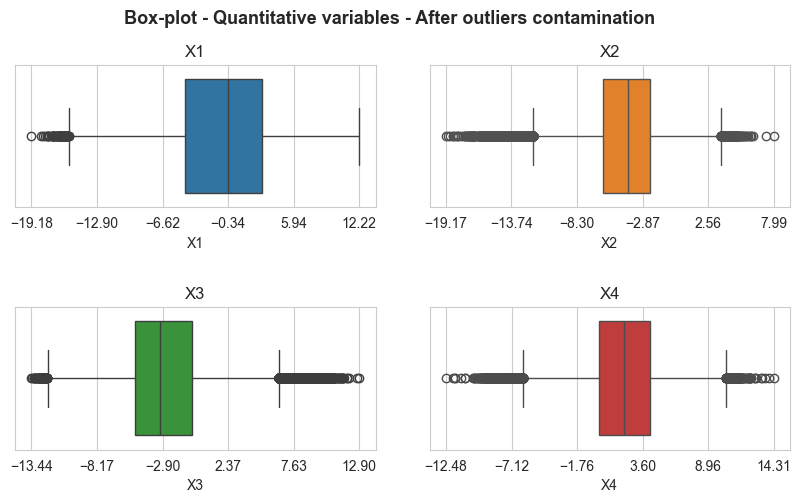

In [7]:
# Boxplot after outliers contamination
boxplot_matrix(X_pl, 
               n_cols=2, 
               title='Box-plot - Quantitative variables - After outliers contamination', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

In [8]:
# Boxplot before outliers contamination
'''
boxplot_matrix(X_not_outliers, 
               n_cols=2, 
               title='Box-plot - Quantitative variables - Before outliers contamination', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)
'''

"\nboxplot_matrix(X_not_outliers, \n               n_cols=2, \n               title='Box-plot - Quantitative variables - Before outliers contamination', \n               figsize=(10,5), \n               quant_col_names=['X1', 'X2', 'X3', 'X4'], \n               n_xticks=6, \n               title_fontsize=13, \n               save=False, \n               file_name='', \n               x_rotation=0, \n               title_height=0.99,\n               style='whitegrid', \n               hspace=0.7, \n               wspace=0.15, \n               title_weight='bold',\n               subtitles_fontsize=12, \n               xlabel_size=10)\n"

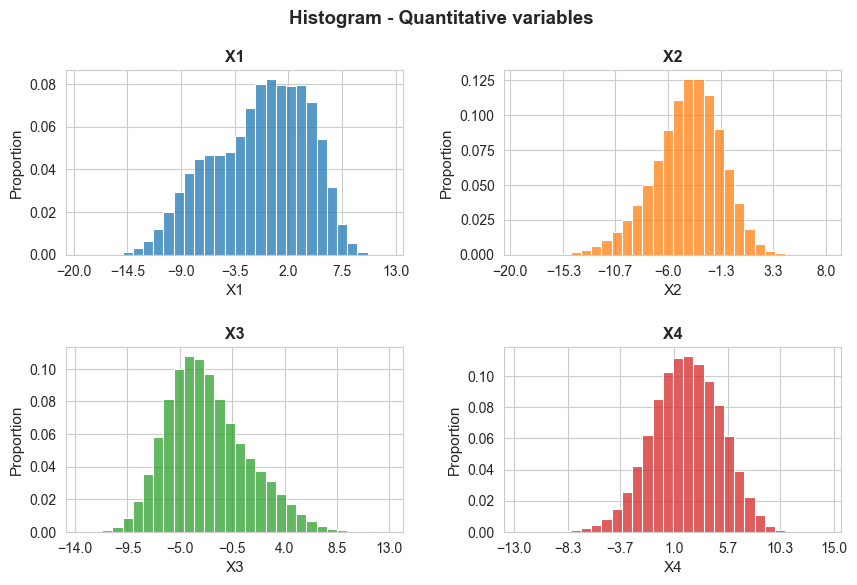

In [9]:
# Histogram
histogram_matrix(df=X_pl, bins=30, n_cols=2, title='Histogram - Quantitative variables', 
                 figsize=(10,6), quant_col_names=['X1', 'X2', 'X3', 'X4'], 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

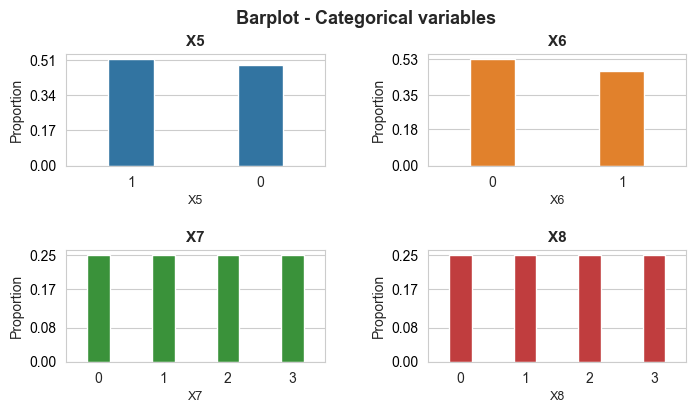

In [10]:
# Barplot
barplot_matrix(df=X_pl, n_cols=2, title='Barplot - Categorical variables', 
                 figsize=(8,4), cat_col_names=['X5', 'X6', 'X7', 'X8'], 
                 title_fontsize=13, subtitles_fontsize=11, 
                 save=False, file_name='', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.75, wspace=0.4, title_weight='bold', bar_width=0.35,
                 ylabel_size=10, xlabel_size=9, xticks_size=10)

In [11]:
# Correlation Matrix
X[['X1', 'X2', 'X3', 'X4']].corr()

,X1,X2,X3,X4
X1,1.000000,0.305141,-0.632135,0.097587
X2,0.305141,1.000000,-0.269765,0.321700
X3,-0.632135,-0.269765,1.000000,-0.099761
X4,0.097587,0.321700,-0.099761,1.000000


In [12]:
# Correlation Analysis
corr_matrix = X[['X1', 'X2', 'X3', 'X4']].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.17
Proportion of pair-wise correlations in [0.30, 0.60]:  0.33
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.5


## Experiment 1: Accuracy and computation time for Fast k-medoids (section 3.2)

In [8]:
run_experiment_1 = True

In [ ]:
if run_experiment_1: 
        
    n_realizations = 70
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', '..',  'results', 'results_experiment_1', 'simulation_6')
    os.makedirs(results_folder_path, exist_ok=True)
    #file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = "20250825_010711"

    experiment_1_config = get_config_exp_1_sim_7()

    X, y = get_simulation_7(random_state=experiment_random_state)

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks[:5], desc='chunks', unit='chunks'), start=0):
        print("chunk_id:", chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**experiment_1_config,
                                                      X=X, 
                                                      y=y,
                                                      random_state=random_state)
            
        # Save results
        results_filename = f'results_exp_1_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 70 realization 
## IBiDat Server:  mins =  hours

chunks:   0%|          | 0/5 [00:00<?, ?chunks/s]

chunk_id: 0
random_state_chunk: [6863, 35084, 11427]
random_state: 6863
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 35084
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 11427
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  20%|██        | 1/5 [1:20:34<5:22:19, 4834.86s/chunks]

chunk_id: 1
random_state_chunk: [53377, 34937, 14116]
random_state: 53377
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 34937
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 14116
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  40%|████      | 2/5 [2:40:56<4:01:21, 4827.14s/chunks]

chunk_id: 2
random_state_chunk: [5000, 49692, 43541]
random_state: 5000
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 49692
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 43541
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  60%|██████    | 3/5 [3:56:34<2:36:29, 4694.95s/chunks]

chunk_id: 3
random_state_chunk: [44669, 6802, 20927]
random_state: 44669
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 6802
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 20927
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  80%|████████  | 4/5 [5:17:50<1:19:26, 4766.48s/chunks]

chunk_id: 4
random_state_chunk: [17702, 44199, 43751]
random_state: 17702
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 44199
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 43751
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks: 100%|██████████| 5/5 [6:39:24<00:00, 4792.98s/chunks]  


In [ ]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_chunk = {}
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'simulation_6')
    file_id = "20250825_010711"
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_simu_7_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [25]:
# Open merged/joined results 
file_id = '20250825_010711'
results_filename = f'results_exp_1_simu_7_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'simulation_6')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [26]:
experiment_1_config = get_config_exp_1_sim_7()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [27]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

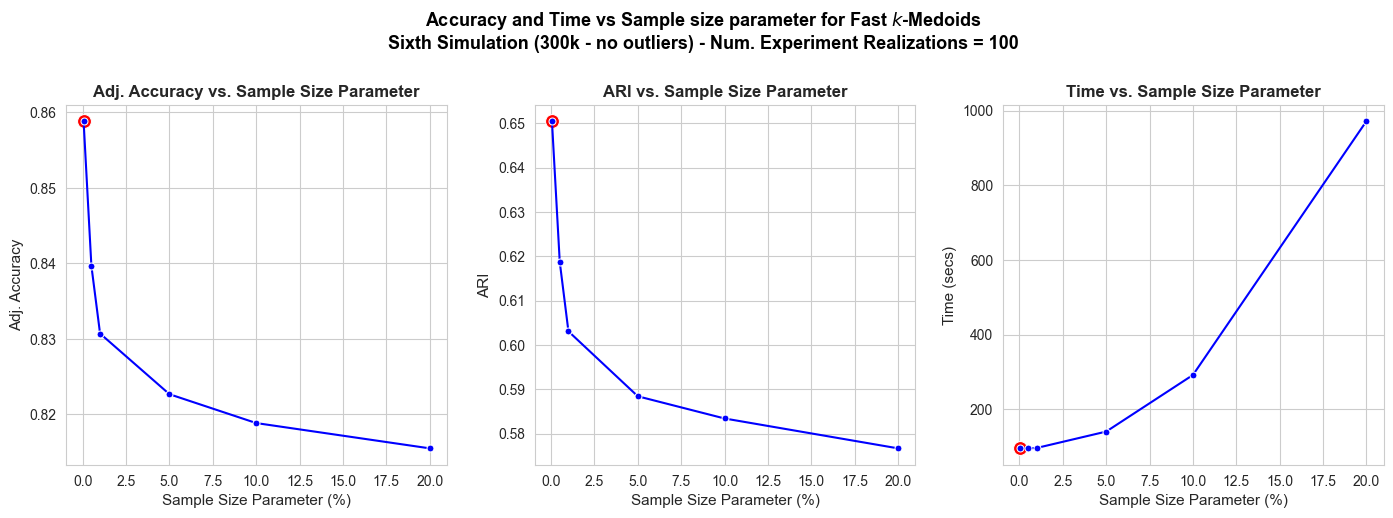

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs. Sample Size Parameter', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size Parameter', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size Parameter', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy and Time vs Sample size parameter for Fast $k$-Medoids\nSixth Simulation (300k - no outliers) - Num. Experiment Realizations = 100', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_simu_7_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [16]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.0005,95.925711,0.858842,0.650468
0.0050,95.091455,0.839661,0.618712
0.0100,96.209598,0.830705,0.603074
0.0500,140.071712,0.822672,0.588433
0.1000,291.792339,0.818853,0.583431
0.2000,972.194538,0.815504,0.576697


In [18]:
print(best_frac_sample_size)

0.0005



## Experiment 3: Accuracy, computation time and number of folds for q-Fold Fast k-medoids (section 3.4)

In [21]:
run_experiment_3 = True

In [ ]:
if run_experiment_3: 

    n_realizations = 70
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'simulation_6')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    experiment_3_config = get_config_exp_3_sim_7()

    X, y = get_simulation_7(random_state=experiment_random_state)

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks[5:]), start=5):
        print('random_state_chunk:', random_state_chunk)


        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**experiment_3_config,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state)

        # Save results
        results_filename = f'results_exp_3_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 70 realization
## IBiDat Server:  mins =  hours 

  0%|          | 0/19 [00:00<?, ?it/s]

random_state_chunk: [32134, 21466, 218]
random_state: 32134
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.03s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.89s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:44<00:00, 32.86s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:39<00:00,  9.97s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.63s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.04s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


random_state: 21466
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.06s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.68s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:41<00:00, 32.21s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.14s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.61s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.01s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 218
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.07s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:00<00:00, 24.16s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.28s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.30s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.08s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.75s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.04s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


  5%|▌         | 1/19 [1:22:38<24:47:32, 4958.45s/it]

random_state_chunk: [57183, 11483, 49492]
random_state: 57183
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.00s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.46s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.21s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.12s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.94s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.02s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 11483
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.08s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:04<00:00, 24.82s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:31<00:00, 30.22s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.12s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.82s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 49492
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.07s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:33<00:00, 30.75s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.12s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:00<00:00, 12.05s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


 11%|█         | 2/19 [2:45:06<23:23:14, 4952.60s/it]

random_state_chunk: [9158, 864, 41347]
random_state: 9158
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.14s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.64s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.37s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.06s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:01<00:00, 12.11s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.45s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


random_state: 864
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.00s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.20s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.10s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.79s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.05s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


random_state: 41347
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.20s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.65s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:38<00:00, 31.70s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.02s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.93s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.72s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


 16%|█▌        | 3/19 [4:07:36<22:00:16, 4951.05s/it]

random_state_chunk: [58762, 13374, 5752]
random_state: 58762
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:34<00:00, 18.98s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.16s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.28s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.71s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.04s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.45s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 13374
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.26s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.11s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.44s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:38<00:00, 31.63s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.07s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.66s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.05s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


random_state: 5752
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.29s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.91s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:41<00:00, 32.24s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.05s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.73s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.03s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


 21%|██        | 4/19 [5:30:04<20:37:30, 4950.00s/it]

random_state_chunk: [12158, 18635, 16547]
random_state: 12158
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.07s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.68s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:38<00:00, 31.77s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.09s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.83s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.45s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 18635
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.05s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.69s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:41<00:00, 32.28s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.10s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.92s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.05s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 16547
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.16s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.06s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.66s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.24s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.07s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.71s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


 26%|██▋       | 5/19 [6:52:40<19:15:30, 4952.18s/it]

random_state_chunk: [2783, 38247, 56444]
random_state: 2783
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.10s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:43<00:00, 32.66s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.10s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.99s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.00s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 38247
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.01s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:54<00:00, 22.92s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:30<00:00, 30.07s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:39<00:00,  9.98s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.73s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.03s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 56444
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.09s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:00<00:00, 24.16s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:46<00:00, 33.23s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.10s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.83s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.02s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


 32%|███▏      | 6/19 [8:15:09<17:52:45, 4951.16s/it]

random_state_chunk: [62511, 34776, 61511]
random_state: 62511
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.03s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.33s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:35<00:00, 31.12s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.06s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.70s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.64s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.01s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


random_state: 34776
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.01s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.37s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:40<00:00, 32.12s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.07s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.83s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.64s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.05s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 61511
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.02s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.16s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:38<00:00, 31.66s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.11s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.73s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.64s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.02s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


 37%|███▋      | 7/19 [9:37:30<16:29:34, 4947.89s/it]

random_state_chunk: [4816, 39989, 45018]
random_state: 4816
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.05s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.12s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:35<00:00, 31.14s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.01s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.92s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


random_state: 39989
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.08s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.17s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:40<00:00, 32.13s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.08s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.94s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.03s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 45018
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.15s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:35<00:00, 31.18s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.02s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.99s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.02s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.40s/it]


frac_sample_size: 0.15


 42%|████▏     | 8/19 [10:59:56<15:06:58, 4947.18s/it]

random_state_chunk: [68376, 63302, 27113]
random_state: 68376
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.21s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.05s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.88s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:43<00:00, 32.70s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.65s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.64s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


random_state: 63302
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:34<00:00, 18.98s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:33<00:00, 30.66s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.03s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.87s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 27113
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.08s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.37s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:33<00:00, 30.62s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.07s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.98s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.45s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


 47%|████▋     | 9/19 [12:22:21<13:44:25, 4946.53s/it]

random_state_chunk: [69084, 41322, 1644]
random_state: 69084
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.02s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:54<00:00, 22.96s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:30<00:00, 30.13s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:39<00:00,  9.99s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.87s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


random_state: 41322
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:30<00:00, 18.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.17s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.67s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:35<00:00, 31.13s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.64s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.00s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 1644
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.32s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.64s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:41<00:00, 32.27s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.20s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.86s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.01s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.40s/it]


frac_sample_size: 0.15


 53%|█████▎    | 10/19 [13:44:42<12:21:43, 4944.89s/it]

random_state_chunk: [52197, 67207, 56935]
random_state: 52197
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.25s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:34<00:00, 18.99s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.25s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:35<00:00, 31.19s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.11s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.87s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.45s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:35<00:00,  2.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 67207
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.23s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.45s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.25s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.06s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.72s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.03s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:29<00:00,  3.74s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:28<00:00,  3.71s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:29<00:00,  3.74s/it]


random_state: 56935
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:21<00:00, 28.26s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:26<00:00, 29.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:55<00:00, 35.20s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:57<00:00, 47.41s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:20<00:00, 14.09s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:18<00:00, 13.84s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:30<00:00, 15.06s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:54<00:00, 17.46s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:22<00:00,  7.13s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:21<00:00,  7.08s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:21<00:00,  7.08s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:29<00:00,  7.46s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.79s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:28<00:00,  3.71s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:24<00:00,  3.60s/it]


frac_sample_size: 0.15


 58%|█████▊    | 11/19 [15:23:44<11:40:00, 5250.02s/it]

random_state_chunk: [63718, 68237, 54984]
random_state: 63718
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.56s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:22<00:00, 28.55s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:55<00:00, 35.03s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:56<00:00, 47.39s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:17<00:00, 13.72s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:22<00:00, 14.22s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:27<00:00, 14.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:49<00:00, 16.94s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:22<00:00,  7.14s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:19<00:00,  6.96s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:19<00:00,  6.98s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:29<00:00,  7.48s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.79s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.79s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:23<00:00,  3.58s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:24<00:00,  3.61s/it]


random_state: 68237
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:15<00:00, 27.11s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:19<00:00, 27.85s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:58<00:00, 35.61s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:45<00:00, 45.09s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:17<00:00, 13.78s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:15<00:00, 13.59s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:30<00:00, 15.08s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:50<00:00, 17.00s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:25<00:00,  7.29s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:18<00:00,  6.92s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:25<00:00,  7.28s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:26<00:00,  7.33s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.80s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:26<00:00,  3.67s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:28<00:00,  3.70s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:26<00:00,  3.66s/it]


random_state: 54984
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:17<00:00, 27.42s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:21<00:00, 28.31s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:53<00:00, 34.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:47<00:00, 45.59s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:18<00:00, 13.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:19<00:00, 13.97s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:30<00:00, 15.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.73s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:21<00:00,  7.08s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:22<00:00,  7.10s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:23<00:00,  7.17s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:29<00:00,  7.45s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:30<00:00,  3.77s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:27<00:00,  3.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:25<00:00,  3.64s/it]


frac_sample_size: 0.15


 63%|██████▎   | 12/19 [17:26:48<11:28:14, 5899.17s/it]

random_state_chunk: [49089, 66855, 4173]
random_state: 49089
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:17<00:00, 27.50s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:20<00:00, 28.20s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:49<00:00, 33.99s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:44<00:00, 44.80s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:19<00:00, 13.98s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:19<00:00, 13.93s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:29<00:00, 14.98s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:50<00:00, 17.05s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:26<00:00,  7.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:22<00:00,  7.11s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:22<00:00,  7.11s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:28<00:00,  7.42s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.78s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:26<00:00,  3.67s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:22<00:00,  3.55s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:26<00:00,  3.67s/it]


random_state: 66855
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:17<00:00, 27.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:19<00:00, 27.99s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:52<00:00, 34.41s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:47<00:00, 45.59s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:18<00:00, 13.87s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:19<00:00, 13.99s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:25<00:00, 14.54s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:51<00:00, 17.18s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:20<00:00,  7.00s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:21<00:00,  7.08s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:30<00:00,  7.52s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:11<00:00,  3.28s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:03<00:00,  3.09s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:02<00:00,  3.05s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.13s/it]


random_state: 4173
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.26s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.95s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:25<00:00, 29.06s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:20<00:00, 40.17s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.68s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.80s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:07<00:00, 12.71s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:27<00:00, 14.79s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:47<00:00,  5.36s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.71s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.80s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:42<00:00,  2.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.48s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.46s/it]


frac_sample_size: 0.15


 68%|██████▊   | 13/19 [19:18:47<10:14:44, 6147.45s/it]

random_state_chunk: [23784, 10827, 63819]
random_state: 23784
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.45s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.48s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:40<00:00, 32.06s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.32s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:34<00:00,  9.40s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.96s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.83s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.70s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.84s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.17s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.48s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.47s/it]


random_state: 10827
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.45s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.31s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.95s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:42<00:00, 32.60s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.35s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.14s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.91s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.75s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.47s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.46s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.48s/it]


random_state: 63819
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.47s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.35s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:01<00:00, 24.20s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:42<00:00, 32.49s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.37s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.36s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:00<00:00, 12.08s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.48s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.15


 74%|███████▎  | 14/19 [20:42:37<8:04:09, 5809.91s/it] 

random_state_chunk: [34326, 22298, 43896]
random_state: 34326
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.31s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.96s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:38<00:00, 31.64s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.39s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.37s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.97s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.71s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.80s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:42<00:00,  2.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.49s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.46s/it]


random_state: 22298
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.54s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.35s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:00<00:00, 24.19s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:45<00:00, 33.15s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.37s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.38s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:02<00:00, 12.21s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.72s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.47s/it]


random_state: 43896
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.40s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:37<00:00, 19.49s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.55s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:40<00:00, 32.08s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:34<00:00,  9.40s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:34<00:00,  9.42s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.08s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.85s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.83s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.20s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.47s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


 79%|███████▉  | 15/19 [22:06:25<6:11:37, 5574.36s/it]

random_state_chunk: [44160, 51274, 9606]
random_state: 44160
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.44s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.21s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.93s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:38<00:00, 31.61s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.38s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.35s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:01<00:00, 12.11s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.72s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.47s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.47s/it]


random_state: 51274
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.43s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.32s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.53s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:35<00:00, 31.02s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.37s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.34s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.91s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.80s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.70s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.47s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.48s/it]


random_state: 9606
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.40s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.16s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.65s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:40<00:00, 32.01s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.34s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.76s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.72s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.46s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


 84%|████████▍ | 16/19 [23:29:47<4:30:06, 5402.00s/it]

random_state_chunk: [59869, 50810, 44054]
random_state: 59869
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.39s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.19s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.91s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:40<00:00, 32.08s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.35s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.85s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.80s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.80s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.47s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.45s/it]


random_state: 50810
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.38s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.15s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.21s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:37<00:00, 31.56s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.33s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.09s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.70s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.70s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.80s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.46s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.46s/it]


random_state: 44054
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.36s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.19s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.84s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:34<00:00, 30.98s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.32s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.33s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.28s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.87s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.80s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.47s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


 89%|████████▉ | 17/19 [24:52:53<2:55:53, 5276.84s/it]

random_state_chunk: [2137, 24780, 11554]
random_state: 2137
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.40s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.34s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.86s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:45<00:00, 33.10s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.30s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.11s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.84s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.70s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.80s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.46s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.45s/it]


random_state: 24780
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.38s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:37<00:00, 19.42s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.25s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:37<00:00, 31.52s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.34s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.24s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.96s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.46s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


random_state: 11554
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.36s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.39s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.90s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:37<00:00, 31.53s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.91s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.70s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.05s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.46s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


 95%|█████████▍| 18/19 [26:16:08<1:26:32, 5192.17s/it]

random_state_chunk: [47646]
random_state: 47646
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.38s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.32s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.46s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:35<00:00, 31.05s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.39s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.35s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.21s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.87s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.80s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.47s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


100%|██████████| 19/19 [26:43:49<00:00, 5064.69s/it]  


In [ ]:
if run_experiment_3: 

    # Open results by chunk
    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'simulation_6')
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_simu_7_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [3]:
# Open merged/joined results 
file_id = "20250827_064929"
results_filename = f'results_exp_3_simu_7_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'simulation_6')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [4]:
experiment_3_config = get_config_exp_3_sim_7()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

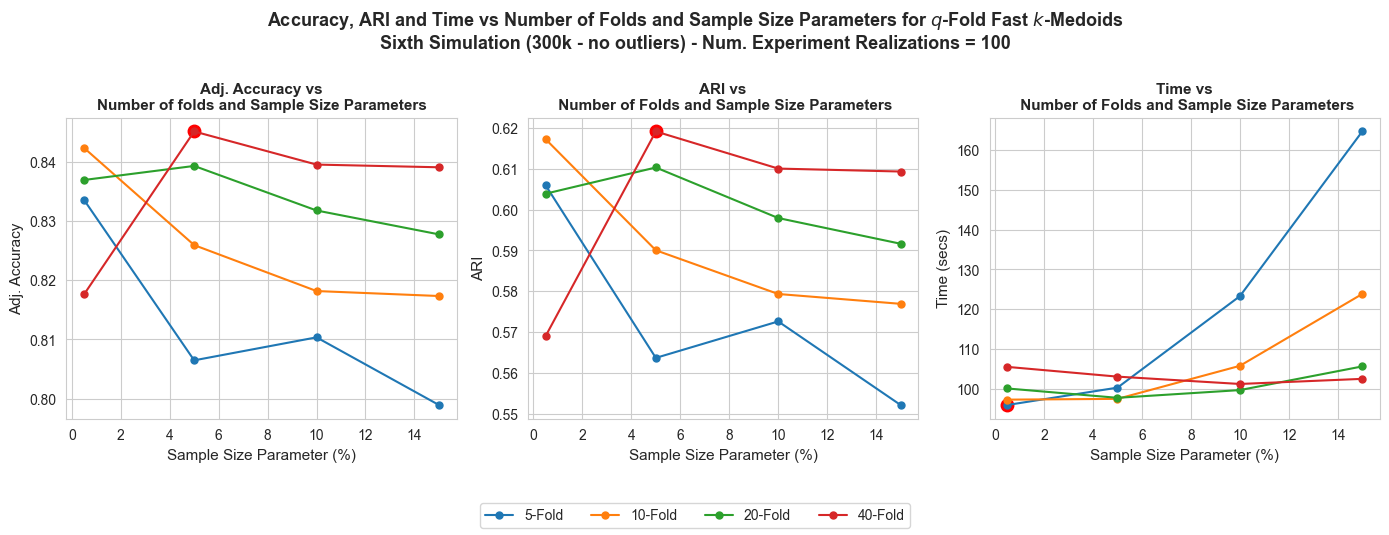

In [5]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(14, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of folds and Sample Size Parameters", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size = 11)
ax1.set_ylabel("Adj. Accuracy",  size = 11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of Folds and Sample Size Parameters", fontsize=11, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size = 11)
ax2.set_ylabel("ARI",  size = 11)

# Tercer subplot: Time
ax3 = axes[2]
ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of Folds and Sample Size Parameters", fontsize=11, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size = 11)
ax3.set_ylabel("Time (secs)",  size = 11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs Number of Folds and Sample Size Parameters for $q$-Fold Fast $k$-Medoids\nSixth Simulation (300k - no outliers) - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_simu_7_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()


In [28]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.005,0.833552,0.605903,95.892305
1,5,0.050,0.806475,0.563752,100.261370
2,5,0.100,0.810354,0.572662,123.274328
3,5,0.150,0.798940,0.552241,164.726286
4,10,0.005,0.842325,0.617186,97.236724
5,10,0.050,0.825920,0.590050,97.434771
6,10,0.100,0.818169,0.579367,105.745598
7,10,0.150,0.817330,0.576963,123.829185
8,20,0.005,0.836908,0.603883,100.046091
9,20,0.050,0.839280,0.610281,97.697980


In [29]:
best_frac_sample_size = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['frac_sample_sizes']
best_n_splits = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['n_splits']
n = len(X)
split_ratio = np.round((best_n_splits/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_n_splits, '\n', 'best_frac_sample_size', best_frac_sample_size)

 split_ratio 0.013 
 best_n_splits 40.0 
 best_frac_sample_size 0.05


## Experiment 4: Empirical comparison to other existing algorithms (section 3.5)

In [4]:
run_experiment_4 = True

In [8]:
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans
from clustpy.hierarchical import Diana

experiment_4_config = get_config_exp_4_sim_7()

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

models = {
    
    'KMeans': KMeans(
        n_clusters=experiment_4_config['n_clusters'], 
        random_state=experiment_4_config['random_state'], 
        init='k-means++', 
        n_init='auto', 
        max_iter=experiment_4_config['max_iter']),

    'CLARA': CLARA(n_clusters=experiment_4_config['n_clusters'], 
                   metric='euclidean'),

    'LDAKmeans': LDAKmeans(n_clusters=experiment_4_config['n_clusters']),

    'SubKmeans': SubKmeans(n_clusters=experiment_4_config['n_clusters']),

    'GaussianMixture': GaussianMixture(n_components=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state']),

    'SpectralBiclustering': SpectralBiclustering(n_clusters=experiment_4_config['n_clusters']),

    'SpectralCoclustering': SpectralCoclustering(n_clusters=experiment_4_config['n_clusters']),

    'BisectingKMeans': BisectingKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter']),

    'MiniBatchKMeans': MiniBatchKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter'])
                                       
}

#################################################################################################

for d in GGower_distances_names:

    d1, d2, d3 = d.split('-')

    if 'robust' in d1:
        r = d1.split('_')[-1]
        d1 = '_'.join(d1.split('_')[:2])
        
    models[f'FastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples']) 

    models[f'FoldFastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FoldFastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples'],
            n_splits=experiment_4_config['n_splits'], 
            shuffle=experiment_4_config['shuffle'], 
            kfold_random_state=experiment_4_config['kfold_random_state']) 

In [ ]:
if run_experiment_4: 
   
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_4', 'simulation_7')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks[32:], desc='chunks', unit='chunks'), start=32):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        

            X, y = get_simulation_7(
                random_state=random_state)
            
            results[random_state] = make_experiment_4(
                X=X, 
                y=y, 
                models=models)

        # Save results
        results_filename = f'results_exp_4_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations: 
## IBiDat Server: 2250  mins =  hours 

In [7]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_4', 'simulation_7')
    results_chunk = {}
    file_id = '20250828_120051'
    
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_simu_7_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [6]:
# Open merged/joined results 
file_id = '20250828_120051'
results_filename = f'results_exp_4_simu_7_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_6')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [9]:
model_names = list(models.keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [10]:
avg_results['std_adj_acc'] = {k: np.std(pivoted_results['adj_accuracy'][k]) for k in model_names}
avg_results['std_ARI'] = {k: np.std(pivoted_results['ARI'][k]) for k in model_names}
avg_results['std_time'] = {k: np.std(pivoted_results['time'][k]) for k in model_names}

In [11]:
not_feasible_methods = ['DipInit', 'Spectral-Clustering', 'KMedoids-euclidean', 'Diana', 'AgglomerativeClustering', 'Birch'] # based on previous (TFM) experiments

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0
    avg_results['std_adj_acc'][model_name] = 0
    avg_results['std_ARI'][model_name] = 0
    avg_results['std_time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
std_adj_acc = np.array(list(avg_results['std_adj_acc'].values()))
std_ari = np.array(list(avg_results['std_ARI'].values()))
std_time = np.array(list(avg_results['std_time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

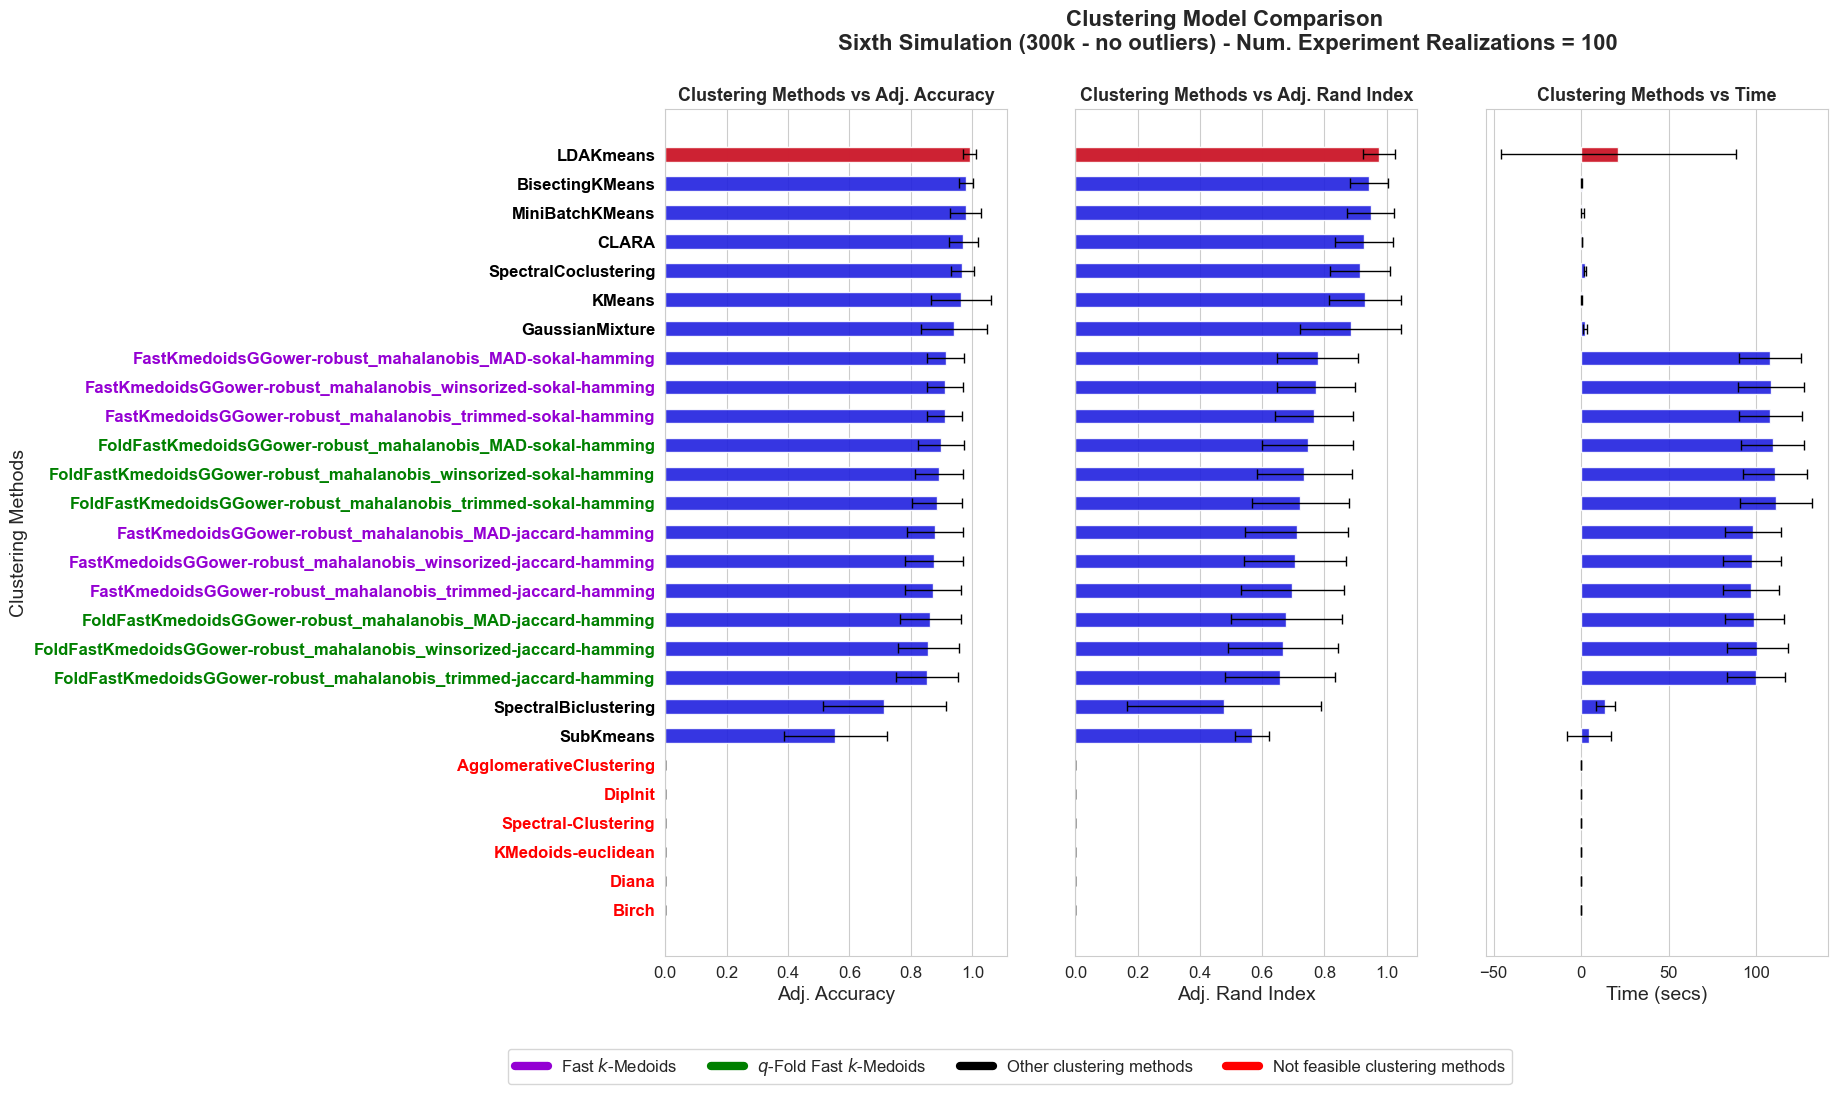

In [12]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

# Añadir barras de error manualmente
axes[0].errorbar(
    x=avg_adj_accuracy[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_adj_acc[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[1].errorbar(
    x=avg_ari[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_ari[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[2].errorbar(
    x=avg_time[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_time[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs Adj. Rand Index', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison \nSixth Simulation (300k - no outliers) - Num. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_simu_7_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [13]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [14]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI,std_adj_acc,std_ARI,std_time
models,,,,,,
LDAKmeans,21.221842,0.991107,0.975212,0.020056,0.051109,66.843903
BisectingKMeans,0.193292,0.979602,0.942781,0.023295,0.062303,0.253350
MiniBatchKMeans,0.652948,0.978772,0.948068,0.050601,0.074161,0.880708
CLARA,0.336419,0.971221,0.926917,0.046267,0.094085,0.082109
SpectralCoclustering,2.112046,0.967968,0.913272,0.038772,0.096246,0.612261
KMeans,0.236445,0.963469,0.931113,0.096631,0.115012,0.105535
GaussianMixture,2.084993,0.939398,0.883641,0.107204,0.160730,0.992530
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,107.956037,0.913493,0.778455,0.061022,0.129640,17.711064
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,108.138680,0.911593,0.772661,0.058080,0.124553,18.874683


In [15]:
avg_results_df_sorted_ari

,time,adj_accuracy,ARI,std_adj_acc,std_ARI,std_time
models,,,,,,
LDAKmeans,21.221842,0.991107,0.975212,0.020056,0.051109,66.843903
MiniBatchKMeans,0.652948,0.978772,0.948068,0.050601,0.074161,0.880708
BisectingKMeans,0.193292,0.979602,0.942781,0.023295,0.062303,0.253350
KMeans,0.236445,0.963469,0.931113,0.096631,0.115012,0.105535
CLARA,0.336419,0.971221,0.926917,0.046267,0.094085,0.082109
SpectralCoclustering,2.112046,0.967968,0.913272,0.038772,0.096246,0.612261
GaussianMixture,2.084993,0.939398,0.883641,0.107204,0.160730,0.992530
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,107.956037,0.913493,0.778455,0.061022,0.129640,17.711064
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,108.138680,0.911593,0.772661,0.058080,0.124553,18.874683


### MDS Visualization

In [17]:
random_state_mds = 20927

X, y = get_simulation_7(random_state=random_state_mds)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.004, random_state=random_state_mds, p1=4, p2=2, p3=2, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

# Time: 7 mins

c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [18]:
sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'GaussianMixture']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}


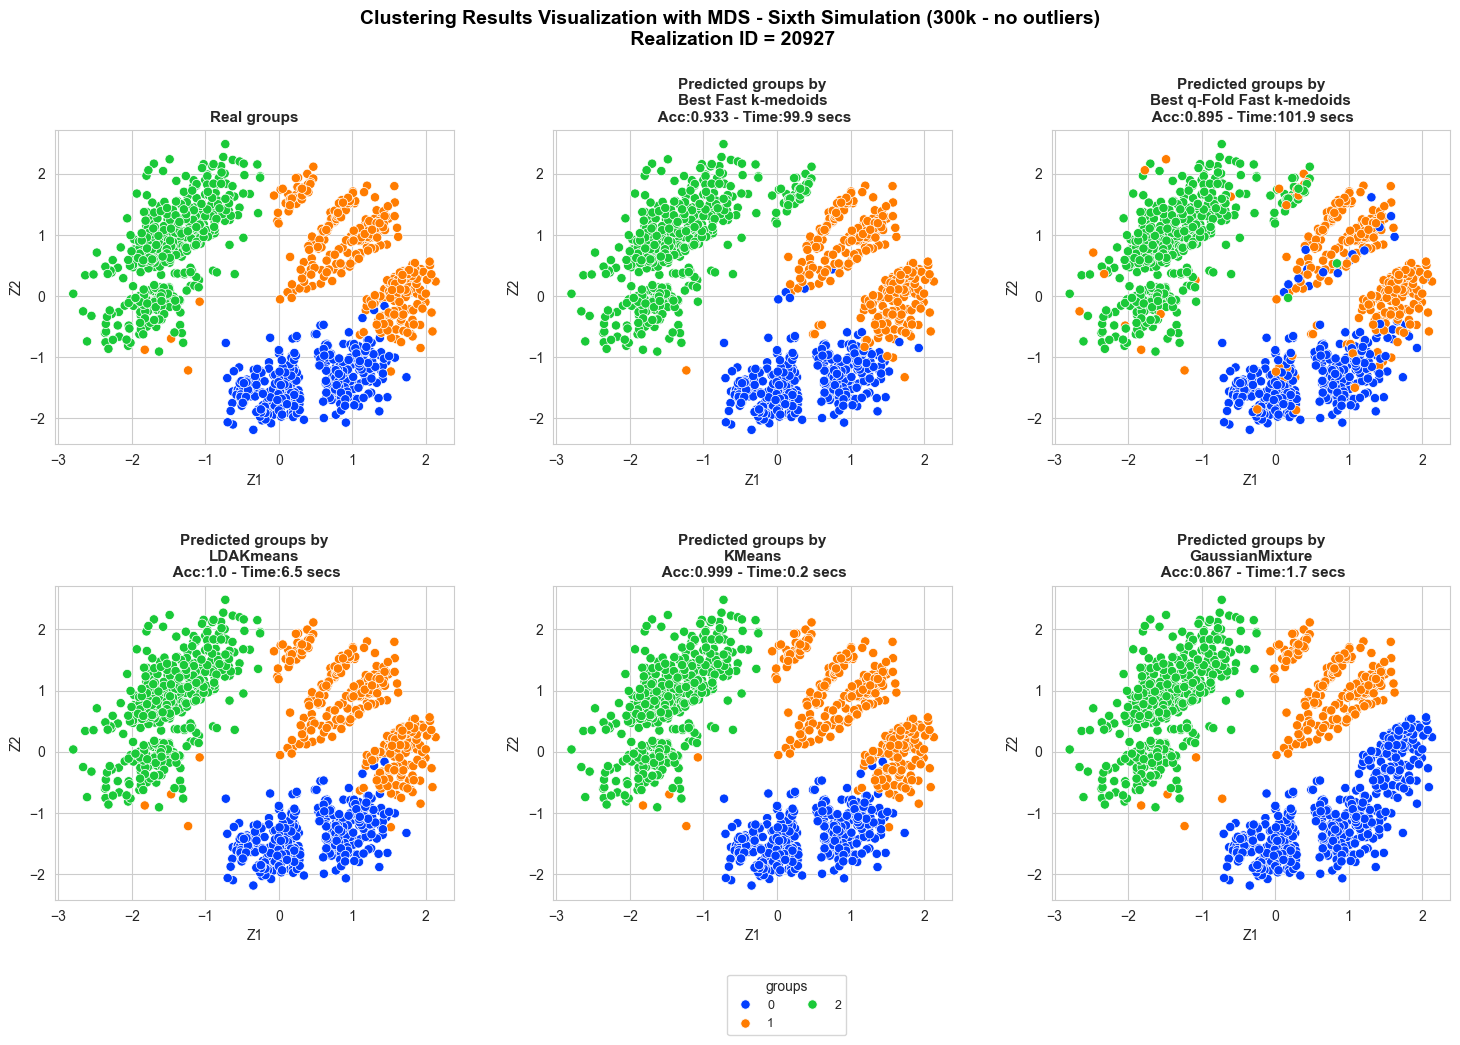

In [19]:
plot_filename = f'mds_plot_exp_4_simu_7_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_6')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Sixth Simulation (300k - no outliers)\n Realization ID = {random_state_mds}", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=14, title_weight='bold', 
                                     subtitles_size=11,
                                     points_size=45, title_height=1, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=None,
                                     n_cols_legend=2, legend_title='groups', legend_size=9, 
                                     save = True, file_name = plot_save_path
)